# Choosing Resolution Parameters

The only real choices to be made when using ``hankel`` are the choice of resolution parameters $N$ and $h$. Roughly speaking, $h$ controls the quadrature bin width, while $N$ controls the number of these bins, ideally simulating infinity. Here we identify some rules of thumb for choosing these parameters so that desired precision can be attained.

For ease of reference, we state our problem explicitly. 
We'll deal first with the simple Hankel integral, moving onto a transformation, and Symmetric FT in later sections.
For an input function $f(x)$, and transform of order $\nu$, we are required to solve the Hankel integral
\begin{equation}
\int_0^\infty f(x) J_\nu(x) dr.
\end{equation}

The O5 method approximates the integral as
\begin{equation}
\hat{f}(K) = \pi \sum_{k=1}^N w_{\nu k} f\left(y_{\nu k}\right)J_\nu(y_{\nu k})\psi'(hr_{\nu k}),
\end{equation}
and we recall that $y_{\nu k}$, $\psi$, $\psi'$ and $w_{\nu k}$ are 
\begin{align}
y_{\nu k} &= \pi \psi(hr_{\nu k})/h \\
\psi(t) &= t\tanh(\pi \sinh(t)/2) \\
\psi'(t) &= \frac{\pi t \cosh(t) + \sinh(\pi \sinh(t))}{ 1 + \cosh(\pi \sinh(t))} \\
w_{\nu k} &= \frac{Y_\nu(\pi r_{\nu k})}{J_{\nu+1}(\pi r_{\nu k})}.
\end{align}

## Simple Hankel Integral

### Choosing N given h

Choosing a good value of $N$ given $h$ is a reasonably simple task. 
The benefit of the O5 method is that the successive nodes approach the roots of the Bessel function double-exponentially.
This means that at some term $k$ in the series, the Bessel function term in the sum approaches zero, and for reasonably low $k$. 

This is because for large $t$, $\psi(t) \approx t$, so that $y_{\nu k} \approx \pi r_{\nu k}$, which are the roots ($r$ are the roots scaled by $\pi$). 
Thus we can expect that a plot of the values of $J_\nu(y_{\nu k})$ should fall to zero, and they should do this approximately identically as a function of $hr_{\nu k}$.

In [1]:
from scipy.special import yv,jv
from mpmath import fp as mpm
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from hankel import HankelTransform, SymmetricFourierTransform

In [2]:
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 13
mpl.rcParams['ytick.labelsize'] = 13
mpl.rcParams['font.size'] = 15
mpl.rcParams['axes.titlesize'] = 14

We test our assertion by plotting these values for a range of $\nu$ and $h$:

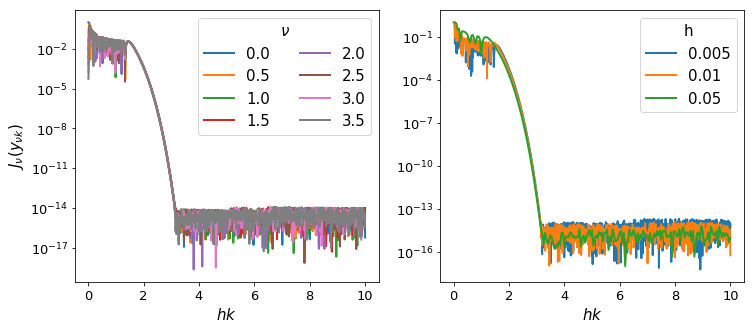

In [15]:
fig,ax = plt.subplots(1,2,figsize=(12,5), subplot_kw={"yscale":'log'})
for nu in np.arange(0,4,0.5):
    ht= HankelTransform(nu=nu,N=1000, h = 0.01)
    ax[0].plot(ht._h*np.arange(1,1001), np.abs(jv(ht._nu, ht.x)), label=str(nu))
    
for h in [0.005,0.01,0.05]:
    ht= HankelTransform(nu=0,N=10/h, h = h)
    ax[1].plot(ht._h*np.arange(1,10/h+1), np.abs(jv(ht._nu, ht.x)), label=str(h))
    
ax[0].legend(ncol=2, title=r"$\nu$")
ax[1].legend(title='h')
ax[0].set_ylabel(r"$J_\nu(y_{\nu k})$")
ax[0].set_xlabel(r"$hk$")
ax[1].set_xlabel(r"$hk$")


plt.savefig("/home/steven/Documents/Projects/HANKEL/laplacian_paper/Figures/h_N_convergence.pdf")

Interestingly, the fall-off is very similar across a range of both $\nu$ and $h$. We can compute where approximately the fall-off is completed:

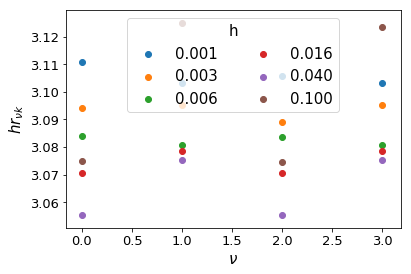

In [4]:
for i,nu in enumerate( np.arange(0,4)):
    for j,h in enumerate(np.logspace(-3,-1,6)):
        ht= HankelTransform(nu=nu,N=int(5./h), h = h)
        plt.scatter(nu,ht._h*ht._zeros[np.where(np.abs(jv(ht._nu, ht.x))<1e-13)[0][0]],color="C%s"%j,label="%.3f"%h if not i else None)
        
plt.xlabel(r"$\nu$")
plt.ylabel(r"$hr_{\nu k}$")
plt.legend(title="h",ncol=2)

Clearly, we can cut the summation at $hr_{\nu k} = 3.2$ without losing any precision. We do not want to sum further than this for two reasons: firstly, it is inefficient to do so, and secondly, we could be adding unnecessary numerical noise.

Now, let's assume that $N$ is reasonably large, so that the Bessel function is close to its asymptotic limit, in which
\begin{equation}
    r_{\nu k} = k - \frac{\pi \nu}{2} - \frac{\pi}{4} \approx k.
\end{equation}
Then we merely set $hr_{\nu k} = hN = 3.2$, i.e. $N = 3.2/h$.

It may be a reasonable question to ask whether we could set $N$ significantly lower than this limit. 
The function $f(x)$ may converge faster than the Bessel function itself, in which case the limit could be reduced. However, for simplicity, for the rest of our analysis, we consider $N$ to be set by this relation, and change $h$ to modify $N$.

### Choosing h

O5 give a rather involved proof of an upper limit on the residual error of their method as a function of $h$. 
Unfortunately, evaluating the upper limit is non-trivial, and we pursue a more tractable approach here.

The effect that $h$ has, given its relation to $N$ above, is to stretch the domain of the integration.
At large $k$, the nodes are given by $y_{\nu k} \approx \pi k$, so that the maximum point evaluated on $f(x)$ is at $x=3.2\pi/h$. 
Given some knowledge of $f$, we can therefore set some limits on the value of $h$.

For instance, the $N^{th}$ term of the sum (if $N$ is high enough) is approximately
\begin{equation}
    G_{\nu} \approx \pi f(3.2\pi/h) J_\nu(3.2\pi/h).
\end{equation}
For large arguments, $J_\nu$ approaches a cosine function:
\begin{equation}
 J_\nu(x) \approx \sqrt{\frac{2}{\pi x}}\left(\cos\left(x-\frac{\nu\pi}{2}-\frac{\pi}{4}\right)\right).
\end{equation}
Taking the amplitude of this function yields
\begin{equation}
    G_{\nu} \approx \sqrt{\frac{2h}{3.2}} f(3.2\pi/h).
\end{equation}


One obvious criterion for $h$ is that $dG/dh$ must be negative, so that the sum is probing the convergent part of the integral. 
However, the most salient criterion for $h$ is that it successfully samples the smallest features in $f(x)$. 
Thus for instance, if $f(x)$ is a narrow Gaussian centred at some $x_0$, then $h$ must be chosen so as to cover the FWHM of the Gaussian adequately.
Alternatively, if $f(x)$ has a lot of information close to $x=0$, then $h$ must be chosen so as to ensure several nodes cover that information. 

Unfortunately, these criteria are not easily solvable, and so we suggest iteratively modifying $h$ until convergence is reached.

As an example, let's take a sharp Gaussian, $f(x) = e^{-(x-80)^2}$ with $\nu=0$:

Integral is:  -0.0965117065719


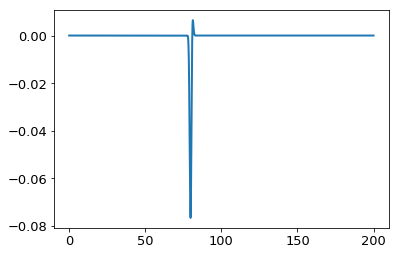

In [3]:
x = np.linspace(0,200.,1000000)
ff = lambda x : np.exp(-(x-80.)**2/1.)
plt.plot(x,ff(x) * jv(0,x))

from scipy.integrate import simps
print "Integral is: ", simps(ff(x) * jv(0,x),x)

100530.964915 True 0.0 -0.0965117065719 10
61911.8148996 True 0.0 -0.0965117065719 8
38128.2804497 True 0.0 -0.0965117058915 6
23481.233306 True 0.0 -0.0965121903118 5
14460.8755251 True 0.0 -0.0962742533513 4
8905.7043226 True 0.0 -0.0955164471316 3
5484.56207535 True 0.0 -0.112512671321 2
3377.65774259 True 0.0 -0.129518816033 2
2080.12447837 True 0.0 -0.027210019158 2
1281.0409388 True 0.0 -0.00944251806079 1
788.92677046 True 0.0 0.0226151150847 1
485.85914025 True 0.0 -0.240786142962 1
299.215482353 True 0.0 0.0230365521459 1
184.27131953 True 0.0 -0.0866049560486 1
113.483162484 True 0.0 -4.70925410083e-06 1
69.8884026016 False 1.18224587086e-45 -5.00649306791e-74 0
43.0406477165 False 0.0 0.0 0
26.5065058993 False 0.0 0.0 0
16.3239842397 False 0.0 0.0 0
10.0530964915 False 0.0 0.0 0


(50, 268753.68203171075)

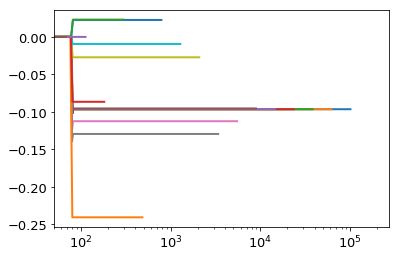

In [6]:
for h in np.logspace(-4,0,20):
    N = int(3.2/h)
    ht = HankelTransform(nu=0, h=h, N=N)
    G = ht.G(ff,h)
    ans,cum  = ht.integrate(f= ff,ret_cumsum=True,ret_err=False)
    print np.pi*3.2/h, N>25, G, ans, np.sum(np.logical_and(ht.x>78,ht.x<82))
    
    plt.plot(ht.x,cum)
plt.xscale('log')
plt.xlim(50,)

In the above example we see that only for very large values of $h$ was the criteria of negative derivative not met. However, the criteria of covering the interesting region with nodes was only met by the smallest 5 values of $h$, each of which yields a good value of the integral. 

Doing the same example, but moving the Gaussian closer to zero yields a different answer:

Integral is:  0.416843377992


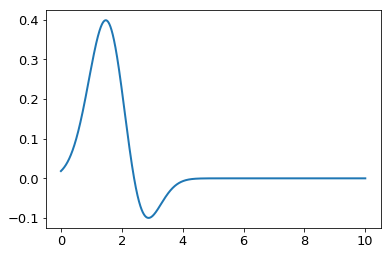

In [12]:
x = np.linspace(0,10,10000)
ff = lambda x : np.exp(-(x-2)**2/1.)
plt.plot(x,ff(x) * jv(0,x))

from scipy.integrate import simps
print "Integral is: ", simps(ff(x) * jv(0,x),x)

100530.964915 True 0.0 0.416843377981 10
61911.8148996 True 0.0 0.416843377981 8
38128.2804497 True 0.0 0.416843377981 6
23481.233306 True 0.0 0.416843377981 5
14460.8755251 True 0.0 0.416843377981 4
8905.7043226 True 0.0 0.416843377981 3
5484.56207535 True 0.0 0.416843377981 2
3377.65774259 True 0.0 0.416843377981 2
2080.12447837 True 0.0 0.416843377721 2
1281.0409388 True 0.0 0.416842995677 1
788.92677046 True 0.0 0.416785363191 1
485.85914025 True 0.0 0.418317506223 1
299.215482353 True 0.0 0.416384483699 1
184.27131953 True 0.0 0.477328299594 1
113.483162484 True 0.0 0.431203499939 1
69.8884026016 False 0.0 0.453832154083 0
43.0406477165 False 0.0 0.00104616438595 0
26.5065058993 False 7.30607651209e-262 0.747476886413 0
16.3239842397 False 4.84891358879e-90 1.37191780468 0
10.0530964915 False 5.40650458253e-29 0.670764719471 0


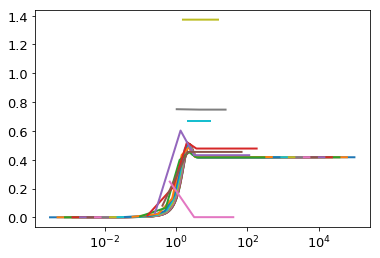

In [8]:
for h in np.logspace(-4,0,20):
    N = int(3.2/h)
    ht = HankelTransform(nu=0, h=h, N=N)
    G = ht.G(ff,h)
    ans,cum  = ht.integrate(f= ff,ret_cumsum=True,ret_err=False)
    print np.pi*3.2/h, N>25, G, ans, np.sum(np.logical_and(ht.x>78,ht.x<82))
    
    plt.plot(ht.x,cum)
plt.xscale('log')

Here we are able to achieve good precision with just ~800 terms.

These ideas are built into the ``get_h`` function in ``hankel``:

In [16]:
from hankel import get_h

In [17]:
get_h(lambda x : np.exp(-(x-2)**2/1.),0)

(0.00625, 0.41684338301151935, 31)

In [55]:
get_h(lambda x : np.exp(-(x-80.)**2),0)

(0.000390625, -0.096511400178473233, 236)

In [56]:
get_h(lambda x : np.exp(-x**2),0,atol=1e-10,rtol=1e-8)

(0.0125, 0.78515069875817434, 21)

## Symmetric Fourier Transform

In the context of the symmetric Fourier Transform, much of the work is exactly the same -- the relationship between $N$ and $h$ necessarily remains. The only differences are that we know use the ``SymmetricFourierTransform`` class instead of the ``HankelTransform`` (and pass ``ndim`` rather than ``nu``), and that we are now interested in the *transform*, rather than the integral, so we have a particular set of scales, $K$, in mind.

For a given $K$, the minimum and maximum values of $x$ that we evaluate $f(x)$ for are $x_{\rm min} \approx \pi^2 h r^2_{\nu 1}/2K$ and $x_{\rm max} \approx \pi N/K$. We suggest find a value $h$ that works for both the minimum and maximum $K$ desired. All scales in between should work in this case.

We have already written this functionality into the ``get_h`` function.

In [57]:
get_h(lambda x : np.exp(-(x-80.)**2),2, K= np.logspace(-2,2,10), cls=SymmetricFourierTransform)

(6.103515625e-06, array([  7.53952457e+02,   8.54080244e+01,   1.78300196e+02,
         -1.25465226e+02,  -9.37124420e+01,   2.30734389e+01,
          1.67032541e-01,  -2.24867894e-13,   2.34702637e-14,
          1.25747785e-14]), 18957)

In [58]:
get_h(lambda x : np.exp(-(x-80.)**2),2, K= np.logspace(-2,2,10), cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, hstart=0.00001)

(5e-06, array([  7.53952144e+02,   8.54080244e+01,   1.78300196e+02,
         -1.25465226e+02,  -9.37124420e+01,   2.30734389e+01,
          1.67032541e-01,   8.68147276e-13,  -1.15869805e-13,
         -5.97366010e-13]), 20928)

For a more sane example

In [61]:
get_h(lambda x : np.exp(-x**2), 2, K= np.logspace(-2,2,10), cls=SymmetricFourierTransform)

(9.765625e-05, array([  3.14151417e+00,   3.14098461e+00,   3.13688784e+00,
          3.10534840e+00,   2.87164359e+00,   1.56688573e+00,
          1.43880563e-02,   1.70297152e-16,  -8.17366143e-17,
         -1.00538714e-16]), 2423)

## Simple Exponential in 2D

Specifically for the transform of $e^{-r^2}$, we know the intermediate form: $-\pi k^2 e^{-k^2/4}$.

In [52]:
f = lambda x : np.exp(-x**2)
fhat = lambda x : np.pi*np.exp(-x**2/4.)
g = lambda x : 4*np.exp(-x**2) * (x**2 - 1)
ghat = lambda x : -x**2*fhat(x)

 Thus for our problem in particular, we can more easily choose the inputs. First, let's define the final set of $r_i$:

In [53]:
rfinal = np.logspace(-2,1,50)

We begin by generating the backwards parameters, which should give us an indication of what range we need to evaluate $\hat{g}(K)$ on. We down-sample the input range of scales because we just care about getting the correct parameters across the board.

In [62]:
hback, res, Nback = get_h(lambda x : -np.pi*x**2 * np.exp(-x**2/4.), nu=2, K=rfinal[::5], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, inverse=True)
hback, Nback, res

(0.0001953125,
 570,
 array([ -3.99919897e+00,  -3.99672507e+00,  -3.98660219e+00,
         -3.94535012e+00,  -3.77974337e+00,  -3.15449842e+00,
         -1.31932539e+00,   5.39979504e-01,   1.01797788e-02,
          1.09299479e-12]))

We can compare this to the truth:

In [63]:
g(rfinal[::5])

array([ -3.99920006e+00,  -3.99672507e+00,  -3.98660219e+00,
        -3.94535012e+00,  -3.77974337e+00,  -3.15449842e+00,
        -1.31932539e+00,   5.39979504e-01,   1.01797788e-02,
         1.09279421e-12])

Given that we know we have to use the K given by the $h$ and $N$ we derived here, we can evaluate these:

In [64]:
sft = SymmetricFourierTransform(2, h=hback, N=Nback)
K_range = [sft.x.min()/rfinal.max(), sft.x.max()/rfinal.min()]
K_range

[5.6476424591524198e-05, 31035.198303127032]

In [65]:
K = np.logspace(np.log10(K_range[0]), np.log10(K_range[1]), 1000)

Let's try to evaluate the forward-transform, on this range of $K$:

In [66]:
hforward, res, Nforward = get_h(lambda x : np.exp(-x**2), nu=2, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, hstart=0.001)
hforward, Nforward, res

(9.765625e-07,
 261372,
 array([  3.14157789e+00,   3.14159263e+00,   3.14159251e+00,
          3.14159160e+00,   3.14158474e+00,   3.14153334e+00,
          3.14114799e+00,   3.13826062e+00,   3.11669911e+00,
          2.95970616e+00,   2.00897355e+00,   1.10017458e-01,
          3.83886676e-11,  -1.23702908e-16,  -8.99054184e-17,
         -7.70683509e-17,   1.02955886e-16,   3.66853159e-17,
         -3.22748661e-17,  -4.72472102e-17]))

This takes a long time, and returns a very small $h$ and high $N$. This is most likely because we are using very small $K$. Taking a look at the plot of $\hat{g}(K)$, we find that we should be able to get away with focusing on the inner part, and the spline should be very accurate towards the edges:

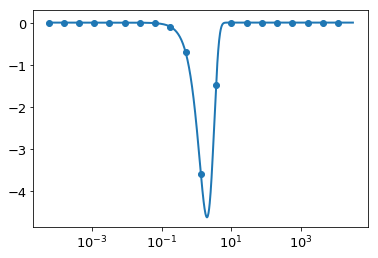

In [68]:
plt.plot(K,ghat(K))
plt.scatter(K[::50], -K[::50]**2 * res)
plt.xscale('log')

Let's set the range of $K$ smaller:

In [71]:
K = np.logspace(-2, 2, 1000)

In [72]:
hforward, res, Nforward = get_h(lambda x : np.exp(-x**2), nu=2, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, hstart=0.001)
hforward, Nforward, res

(0.000125, 1703, array([  3.14151411e+00,   3.14139520e+00,   3.14109623e+00,
          3.14034468e+00,   3.13845594e+00,   3.13371228e+00,
          3.12181741e+00,   3.09211036e+00,   3.01866366e+00,
          2.84161861e+00,   2.44101598e+00,   1.66588629e+00,
          6.37493106e-01,   5.69672988e-02,   1.31402547e-04,
          3.08028340e-11,  -3.61323428e-16,  -4.02706283e-16,
         -3.50161291e-16,  -3.27828863e-16]))

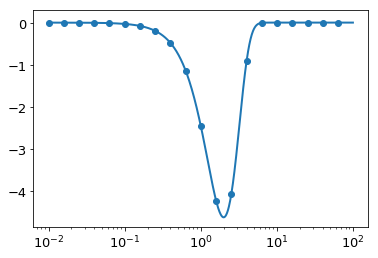

In [73]:
plt.plot(K,ghat(K))
plt.scatter(K[::50], -K[::50]**2 * res)
plt.xscale('log')

Let's now try the entire forwards-then-back solution using the parameters we've optimized. First, we define a function for doing the whole transformation, and also a function for plotting a diagnostic plot:

In [75]:
def ht_transformation_nd(f,N_forward,h_forward,K,r,ndim=2, inverse=False, N_back=None, h_back=None, 
                         ret_everything=False):
    
    if N_back is None:
        N_back = N_forward
    if h_back is None:
        h_back = h_forward
        
    # Get transform of f
    ht = SymmetricFourierTransform(ndim=ndim, N=N_forward, h=h_forward)
    
    if ret_everything:
        fhat, fhat_cumsum = ht.transform(f, K, ret_cumsum=True, ret_err=False)
    else:
        fhat = ht.transform(f, K, ret_err = False)
    
    # Spectral derivative
    if not inverse:
        ghat = -K**2 * fhat
    else:
        ghat = -1./K**2 * fhat
        
    # Transform back to physical space via spline
    # The following should give best resulting splines for most kinds of functions
    # Use log-space y if ghat is either all negative or all positive, otherwise linear-space
    # Use order 1 because if we have to extrapolate, this is more stable.
    # This will not be a good approximation for discontinuous functions... but they shouldn't arise.
    if np.all(ghat<=1e-13):
        g_ = spline(K[ghat<0],np.log(-ghat[ghat<0]),k=1)
        ghat_spline = lambda x : -np.exp(g_(x))
    elif np.all(ghat>=-1e-13):
        g_ = spline(K[ghat<0],np.log(ghat[ghat<0]),k=1)
        ghat_spline = lambda x : np.exp(g_(x))
    else:
        g_ = spline(K,ghat,k=1)
        ghat_spline = g_
        
    if N_back != N_forward or h_back != h_forward:
        ht2 = SymmetricFourierTransform(ndim=ndim, N=N_back, h=h_back)
    else:
        ht2 = ht
        
    if ret_everything:
        g, g_cumsum = ht2.transform(ghat_spline, r, ret_err=False, inverse=True, ret_cumsum=True)
    else:
        g = ht2.transform(ghat_spline, r, ret_err=False, inverse=True)
    
    if ret_everything:
        return g, g_cumsum, fhat,fhat_cumsum, ghat, ht,ht2, ghat_spline
    else:
        return g

In [76]:
def make_diagnostic_plots(K, r, ghat=None,g=None,*args,**kwargs):
    """
    Calls ht_transformation_nd and takes "true" functions to assess the discrepancy.
    """
    
    g_ht, g_cumsum, fhat_ht, fhat_cumsum,ghat_ht, ht1,ht2, ghat_spline = ht_transformation_nd(K=K,r=r,ret_everything=True, *args,**kwargs)
    
    fig, ax = plt.subplots(2,2,figsize=(12,9))
    
    ## Plot g
    ax[0,0].plot(r, g_ht, label="Hankel Transform", lw=2, ls='--')
    ax[0,0].plot(r, g(r), label = "$g(r)$", lw=2, ls = ':')
    ax[0,0].legend(fontsize=15)

    ax[0,0].grid(True)
    ax[0,0].set_ylabel(r"$\tilde{g}(r)$",fontsize=15)
    
    ax[1,0].plot(r, np.abs(g_ht-g(r)),lw=2, ls='--')
    ax[1,0].set_yscale('log')
    ax[1,0].set_ylabel(r"$|\tilde{g}(r)-g(r)|$",fontsize=15)
    ax[1,0].set_xlabel(r"$r$",fontsize=15)
    ax[1,0].grid(True)
    
    
    ## Plot ghat
    ax[0,1].plot(K, ghat_ht, label="Hankel", lw=2, ls='--')
    
    allk = np.logspace(np.log10(ht2.xrange(K)[0]), np.log10(ht2.xrange(K)[1]),1000)
    ax[0,1].plot(allk, ghat_spline(allk), label="Spline",lw=1)
    ax[0,1].plot(K, ghat(K), label = "True", lw=2, ls = ':')
    ax[0,1].legend(fontsize=15)

    ax[0,1].grid(True)
    ax[0,1].set_ylabel(r"$\hat{g}(r)$",fontsize=15)
    ax[0,1].set_xscale('log')
    
    ax[1,1].plot(K, np.abs(ghat_ht-ghat(K)),lw=2, ls='--')
    ax[1,1].plot(allk, np.abs(ghat_spline(allk)-ghat(allk)),lw=2, ls='-')
    
    ax[1,1].set_yscale('log')
    ax[1,1].set_ylabel(r"$|\hat{g}(r)-\hat{g}(r)|$",fontsize=15)
    ax[1,1].set_xlabel(r"$K$",fontsize=15)
    ax[1,1].grid(True)
    ax[1,1].set_xscale('log')
    return fig

In [92]:
g_ht, g_cumsum, fhat_ht, fhat_cumsum,ghat_ht, ht1,ht2, ghat_spline = ht_transformation_nd(lambda x : np.exp(-x**2),N_forward=Nforward, h_forward=hforward, h_back=hback, N_back=Nback, K = K, r = rfinal, ret_everything=True)

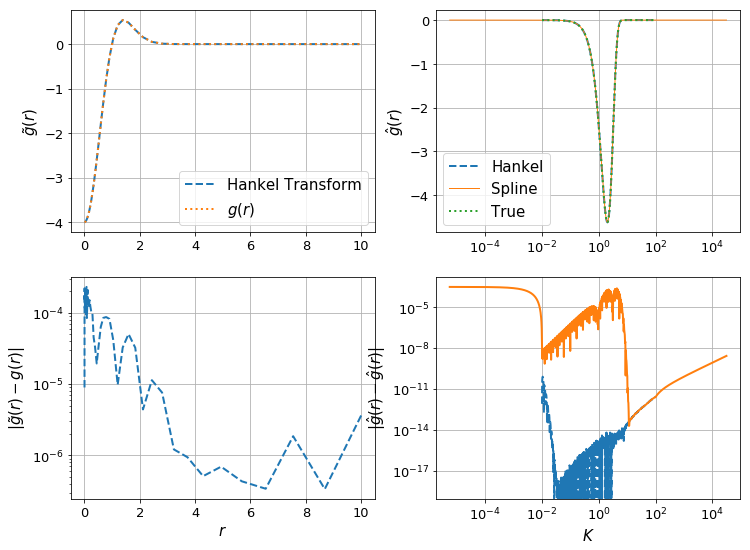

In [80]:
make_diagnostic_plots(K, rfinal, ghat, g, f=lambda x : np.exp(-x**2),N_forward=Nforward, h_forward=hforward, h_back=hback, N_back=Nback);

Let's check the effect of the resolution of $K$:

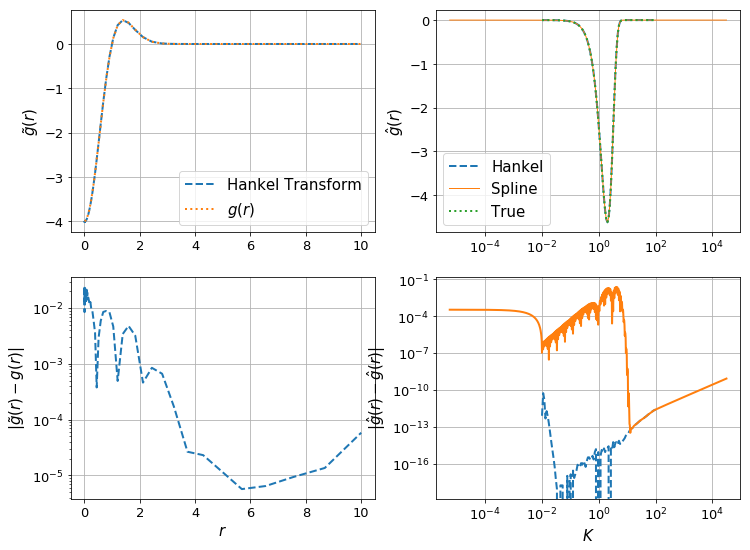

In [82]:
K = np.logspace(-2,2,100)
make_diagnostic_plots(K, rfinal, ghat, g, f=lambda x : np.exp(-x**2),N_forward=Nforward, h_forward=hforward, h_back=hback, N_back=Nback);

The difference can be clearly seen in the orange line in the bottom right plot -- the spline evaluation of $\hat{g}$ is less accurate, and so we have a corresponding drop in accuracy in $g(r)$.

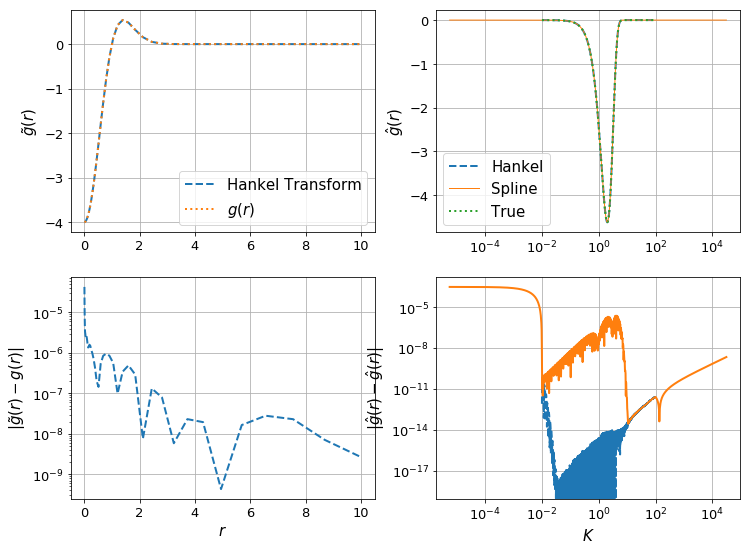

In [83]:
K = np.logspace(-2,2,10000)
make_diagnostic_plots(K, rfinal, ghat, g, f=lambda x : np.exp(-x**2),N_forward=Nforward, h_forward=hforward, h_back=hback, N_back=Nback);

Here we have an increase in precision, by a factor of 10, with an increase in $n_k$ by a factor of 10. We'd probably gain a bit by using a higher-order spline interpolation, however this has bad behaviour when extrapolating, which we need to do here (otherwise we need to use extremely large $N$ to get the highest $K$). 

## SImple Exponential in 3D

In this section, we perform the same analysis as in the previous one, but in 3D, to show that the general process works well.

In [84]:
fhat_3d = lambda x : np.pi**(3./2)*np.exp(-x**2/4.)
g_3d = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.5)
ghat_3d = lambda x : -x**2*fhat_3d(x)

In [94]:
hback, res, Nback = get_h(ghat_3d, nu=3, K=rfinal[::5], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, inverse=True)
hback, Nback, res

(0.0001953125,
 570,
 array([ -5.99899738e+00,  -5.99590626e+00,  -5.98325134e+00,
         -5.93166419e+00,  -5.72429124e+00,  -4.93698196e+00,
         -2.56747300e+00,   2.49885585e-01,   9.44275920e-03,
          1.07502597e-12]))

In [87]:
sft = SymmetricFourierTransform(3, h=hback, N=Nback)
K_range = [sft.x.min()/rfinal.max(), sft.x.max()/rfinal.min()]
K_range

[9.6382853068197814e-05, 31062.217872340836]

In [88]:
K = np.logspace(-2, 2, 1000)

In [89]:
hforward, res, Nforward = get_h(f, nu=3, K=K[::50], cls=SymmetricFourierTransform, atol=1e-8, rtol=1e-4, hstart=0.001)
hforward, Nforward, res

(0.000125, 1703, array([  5.56817071e+00,   5.56797218e+00,   5.56744663e+00,
          5.56611565e+00,   5.56276823e+00,   5.55436038e+00,
          5.53327729e+00,   5.48062292e+00,   5.35044202e+00,
          5.03663785e+00,   4.32658817e+00,   2.95270658e+00,
          1.12992711e+00,   1.00971908e-01,   2.32904950e-04,
          5.45742741e-11,  -5.54278455e-15,  -1.34709891e-15,
         -3.12381267e-16,  -4.35402965e-17]))

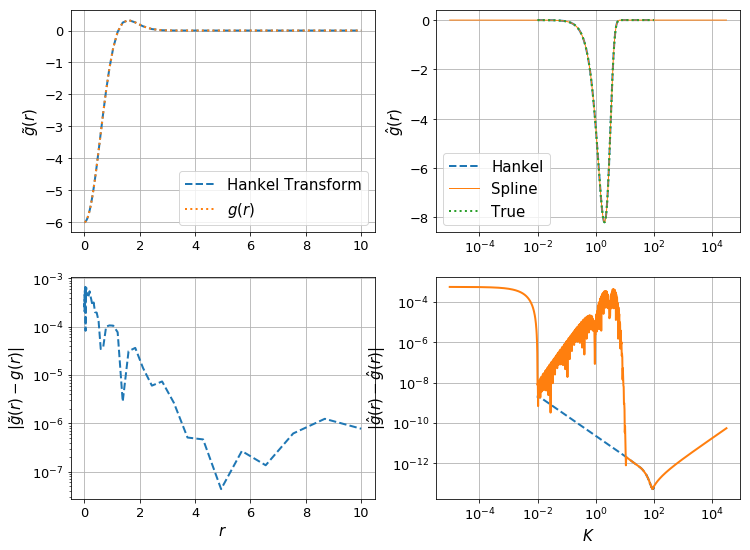

In [91]:
make_diagnostic_plots(K, rfinal, ghat_3d, g_3d, f=f,N_forward=Nforward, h_forward=hforward, h_back=hback, N_back=Nback,ndim=3);